# BYU Locating Flagellar Motors

## Data Visualization Notebook

### About this Notebook

This visualization notebook displays random annotations, for ease of understanding of the dataset

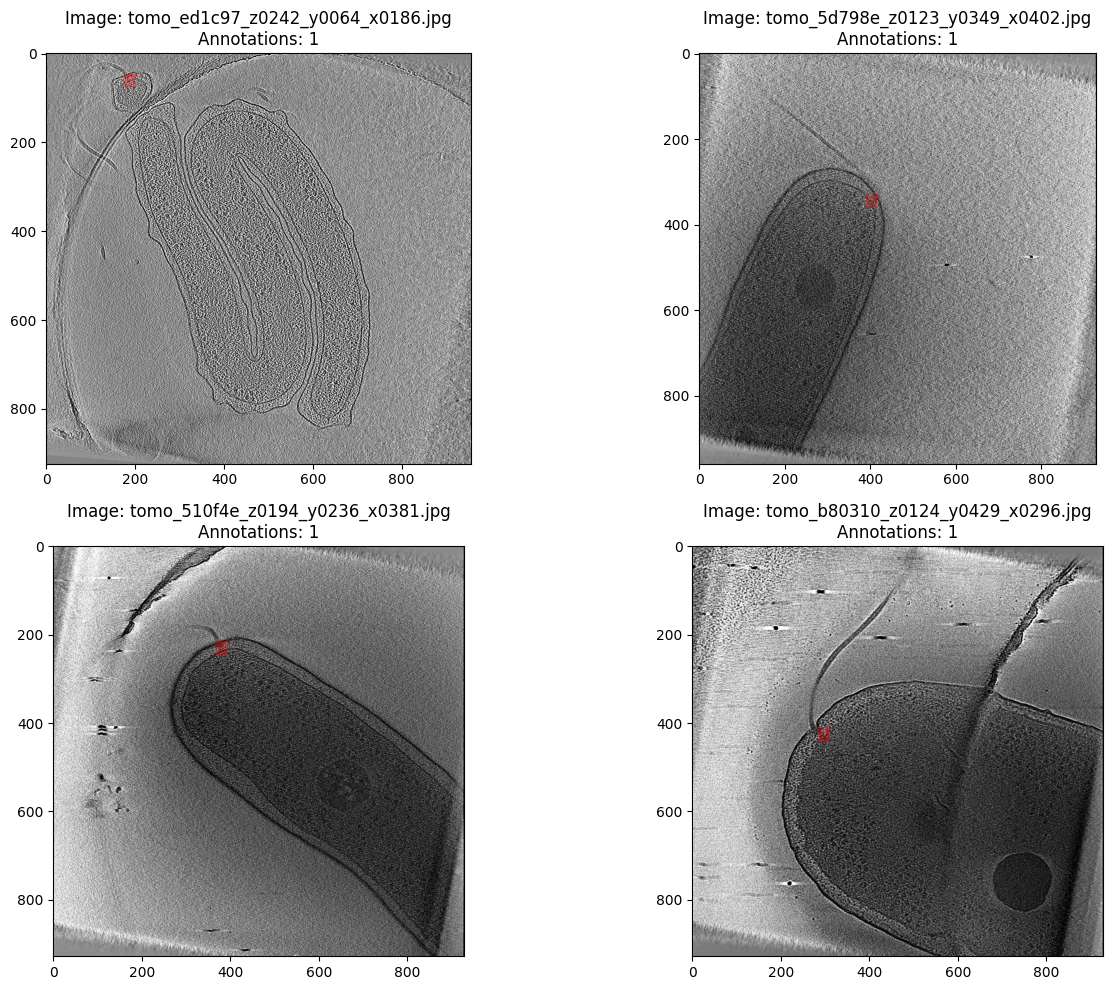

Displayed 4 random images with YOLO annotations


In [1]:
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import numpy as np
import glob

# Define base_dir - this was missing in the original code
# In Kaggle, we can use the working directory as base or remove it completely
# since we're using absolute paths
base_dir = "/kaggle/working"  # or simply use "" if using absolute paths

# Updated paths without concatenating with base_dir since they're already absolute
images_train_dir = "/kaggle/input/parse-data/yolo_dataset/images/train/"
labels_train_dir = "/kaggle/input/parse-data/yolo_dataset/labels/train/"

# Box size for highlighting the motor
BOX_SIZE = 24

def visualize_random_training_samples(num_samples=4):
    """
    Visualize random training samples with YOLO annotations
    
    Args:
        num_samples (int): Number of random images to display
    """
    # Get all image files from the train directory
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        image_files.extend(glob.glob(os.path.join(images_train_dir, "**", ext), recursive=True))
    
    # Make sure we have enough images
    if len(image_files) == 0:
        print("No image files found in the train directory!")
        return
        
    num_samples = min(num_samples, len(image_files))
    
    # Select random images
    random_images = random.sample(image_files, num_samples)
    
    # Create a figure with subplots
    rows = int(np.ceil(num_samples / 2))
    cols = min(num_samples, 2)
    fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
    
    # Handle the case of a single subplot
    if num_samples == 1:
        axes = np.array([axes])
    
    # Flatten axes array for easy indexing
    axes = axes.flatten()
    
    # Process each selected image
    for i, img_path in enumerate(random_images):
        try:
            # Get corresponding label file
            # YOLO labels have same name but .txt extension instead of image extension
            relative_path = os.path.relpath(img_path, images_train_dir)
            label_path = os.path.join(labels_train_dir, os.path.splitext(relative_path)[0] + '.txt')
            
            # Load the image
            img = Image.open(img_path)
            img_width, img_height = img.size
            
            # Normalize image using percentiles for better visualization
            img_array = np.array(img)
            p2 = np.percentile(img_array, 2)
            p98 = np.percentile(img_array, 98)
            normalized = np.clip(img_array, p2, p98)
            normalized = 255 * (normalized - p2) / (p98 - p2)
            img_normalized = Image.fromarray(np.uint8(normalized))
            
            # Convert image to RGB for colored box
            img_rgb = img_normalized.convert('RGB')
            
            # Create a transparent overlay
            overlay = Image.new('RGBA', img_rgb.size, (0, 0, 0, 0))
            draw = ImageDraw.Draw(overlay)
            
            # Load YOLO format annotations if they exist
            annotations = []
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        # YOLO format: class x_center y_center width height
                        # All values are normalized from 0 to 1
                        values = line.strip().split()
                        class_id = int(values[0])
                        x_center = float(values[1]) * img_width
                        y_center = float(values[2]) * img_height
                        width = float(values[3]) * img_width
                        height = float(values[4]) * img_height
                        
                        annotations.append({
                            'class_id': class_id,
                            'x_center': x_center,
                            'y_center': y_center,
                            'width': width,
                            'height': height
                        })
            
            # Draw all annotations
            for ann in annotations:
                x_center = ann['x_center']
                y_center = ann['y_center']
                width = ann['width']
                height = ann['height']
                
                # Calculate bounding box coordinates
                x1 = max(0, int(x_center - width/2))
                y1 = max(0, int(y_center - height/2))
                x2 = min(img_width, int(x_center + width/2))
                y2 = min(img_height, int(y_center + height/2))
                
                # Draw semi-transparent red rectangle
                draw.rectangle([x1, y1, x2, y2], fill=(255, 0, 0, 64), outline=(255, 0, 0, 200))
                
                # Draw label
                label_text = f"Class {ann['class_id']}"
                draw.text((x1, y1-10), label_text, fill=(255, 0, 0, 255))
            
            # If no annotations found, indicate this
            if not annotations:
                draw.text((10, 10), "No annotations found", fill=(255, 0, 0, 255))
            
            # Composite the overlay onto the original image
            img_rgb = Image.alpha_composite(img_rgb.convert('RGBA'), overlay).convert('RGB')
            
            # Display the image with annotations
            axes[i].imshow(np.array(img_rgb))
            img_name = os.path.basename(img_path)
            axes[i].set_title(f"Image: {img_name}\nAnnotations: {len(annotations)}")
            axes[i].axis('on')
            
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            axes[i].text(0.5, 0.5, f"Error loading image: {os.path.basename(img_path)}", 
                       horizontalalignment='center', verticalalignment='center')
            axes[i].axis('off')
    
    # Handle extra subplots if any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"Displayed {num_samples} random images with YOLO annotations")

# Run the visualization
visualize_random_training_samples(4)